In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import albumentations as A
%matplotlib inline

Segmentation Models: using `tf.keras` framework.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15677276692001397375,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3717637016179137383
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6425163883014737125
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 17057651098
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14381171695028816184
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"]

In [3]:
!nvidia-smi
#!kill 105780

Sat Aug 21 14:56:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   59C    P0   289W / 300W |  22813MiB / 32480MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   47C    P0    65W / 300W |  15358MiB / 32480MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
BACKBONE = 'seresnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:
# we create two instances with the same arguments
data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     #shear_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     brightness_range=[0.8, 1.2],
                     zoom_range=0.5,
                     fill_mode='constant',
                     validation_split=0.2)

image_datagen = ImageDataGenerator( **data_gen_args)
mask_datagen = ImageDataGenerator(rescale=1./255, **data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
batch_size=16
train_path='roof_all'
image_folder='image'
mask_folder='labels'
image_color_mode='rgb'
mask_color_mode='grayscale'
target_size=(512,512)
seed=1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)
image_train_generator = image_datagen.flow_from_directory(
    train_path,
    classes = [image_folder],
    class_mode = None,
    color_mode = image_color_mode,
    target_size = target_size,
    subset='training',
    batch_size = batch_size,
    seed = seed)

image_val_generator = image_datagen.flow_from_directory(
    train_path,
    classes = [image_folder],
    class_mode = None,
    color_mode = image_color_mode,
    target_size = target_size,
    subset='validation',
    batch_size = batch_size,
    seed = seed)

mask_train_generator = mask_datagen.flow_from_directory(
    train_path,
    classes = [mask_folder],
    class_mode = None,
    color_mode = mask_color_mode,
    target_size = target_size,
    subset='training',
    batch_size = batch_size,
    seed = seed)

mask_val_generator = mask_datagen.flow_from_directory(
    train_path,
    classes = [mask_folder],
    class_mode = None,
    color_mode = mask_color_mode,
    target_size = target_size,
    subset='validation',
    batch_size = batch_size,
    seed = seed)

train_gen = zip(image_train_generator, mask_train_generator)
val_gen = zip(image_val_generator, mask_val_generator)

Found 9023 images belonging to 1 classes.
Found 2255 images belonging to 1 classes.
Found 9023 images belonging to 1 classes.
Found 2255 images belonging to 1 classes.


In [6]:
#loss = sm.losses.binary_focal_dice_loss
#loss = sm.losses.bce_dice_loss
loss = sm.losses.bce_jaccard_loss #binary_focal_jaccard_loss
#loss = sm.losses.DiceLoss()
#metrics = sm.metrics.iou_score
metrics = sm.metrics.FScore()
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=loss, metrics=[metrics])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 6 256         conv2d[0][0]                     
____________________________________________________________________________________________

__________________________________________________________________________________________________
activation_176 (Activation)     (None, None, None, 2 0           batch_normalization_109[0][0]    
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, None, None, 2 0           activation_176[0][0]             
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, None, None, 2 589824      zero_padding2d_37[0][0]          
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, None, None, 2 1024        conv2d_180[0][0]                 
__________________________________________________________________________________________________
activation_177 (Activation)     (None, None, None, 2 0           batch_normalization_110[0][0]    
__________

In [8]:
callbacks = [
    #keras.callbacks.ModelCheckpoint('./seresnet152_gen_roof_all.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
]

training_samples = image_train_generator.n
validation_samples = image_val_generator.n

history = model.fit(
    train_gen,
    steps_per_epoch=training_samples // batch_size,
    epochs=200,
    validation_data=val_gen, 
    validation_steps=validation_samples // batch_size,
    #workers=1,
    shuffle=True,
    callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 563 steps, validate for 140 steps
Epoch 1/200
563/563 [==============================] - 1071s 2s/step - loss: 0.6389 - f1-score: 0.6943 - val_loss: 0.6764 - val_f1-score: 0.6734
Epoch 2/200
563/563 [==============================] - 1019s 2s/step - loss: 0.5714 - f1-score: 0.7303 - val_loss: 0.6559 - val_f1-score: 0.6904
Epoch 3/200
563/563 [==============================] - 1004s 2s/step - loss: 0.5584 - f1-score: 0.7339 - val_loss: 0.6022 - val_f1-score: 0.7089
Epoch 4/200
563/563 [==============================] - 1003s 2s/step - loss: 0.5551 - f1-score: 0.7382 - val_loss: 0.6044 - val_f1-score: 0.7123
Epoch 5/200
563/563 [==============================] - 1005s 2s/step - loss: 0.5298 - f1-score: 0.7532 - val_loss: 0.6056 - val_f1-score: 0.7114
Epoch 6/200
563/563 [==============================] - 1007s 2s/step - loss: 0.5177 - f1-score: 0.7615 - val_loss: 0.5901 - val_f1-score: 0.7151
Epoch 7/200
563/563 [===============

Epoch 56/200
563/563 [==============================] - 1023s 2s/step - loss: 0.4470 - f1-score: 0.7967 - val_loss: 0.5237 - val_f1-score: 0.7626
Epoch 57/200
563/563 [==============================] - 1024s 2s/step - loss: 0.4450 - f1-score: 0.7988 - val_loss: 0.5260 - val_f1-score: 0.7599
Epoch 58/200
563/563 [==============================] - 1024s 2s/step - loss: 0.4468 - f1-score: 0.7977 - val_loss: 0.5290 - val_f1-score: 0.7634
Epoch 59/200
563/563 [==============================] - 1026s 2s/step - loss: 0.4464 - f1-score: 0.8083 - val_loss: 0.4942 - val_f1-score: 0.7726
Epoch 60/200
563/563 [==============================] - 1027s 2s/step - loss: 0.4413 - f1-score: 0.8098 - val_loss: 0.5075 - val_f1-score: 0.7697
Epoch 61/200
563/563 [==============================] - 1039s 2s/step - loss: 0.4373 - f1-score: 0.8117 - val_loss: 0.5021 - val_f1-score: 0.7706
Epoch 62/200
563/563 [==============================] - 1040s 2s/step - loss: 0.4303 - f1-score: 0.8153 - val_loss: 0.4952 -

563/563 [==============================] - 1113s 2s/step - loss: 0.4159 - f1-score: 0.8235 - val_loss: 0.4821 - val_f1-score: 0.7717
Epoch 113/200
563/563 [==============================] - 1116s 2s/step - loss: 0.4233 - f1-score: 0.8190 - val_loss: 0.4840 - val_f1-score: 0.7752
Epoch 114/200
563/563 [==============================] - 1116s 2s/step - loss: 0.4244 - f1-score: 0.8186 - val_loss: 0.4871 - val_f1-score: 0.7722
Epoch 115/200
563/563 [==============================] - 1114s 2s/step - loss: 0.4221 - f1-score: 0.8206 - val_loss: 0.4857 - val_f1-score: 0.7713
Epoch 116/200
563/563 [==============================] - 1115s 2s/step - loss: 0.4293 - f1-score: 0.8162 - val_loss: 0.4833 - val_f1-score: 0.7717
Epoch 117/200
563/563 [==============================] - 3275s 6s/step - loss: 0.4203 - f1-score: 0.8213 - val_loss: 0.4822 - val_f1-score: 0.7724
Epoch 118/200
563/563 [==============================] - 6016s 11s/step - loss: 0.4314 - f1-score: 0.8165 - val_loss: 0.4809 - val_f

In [9]:
#model.save_weights("seresnet152_gen_roof_all2.h5")

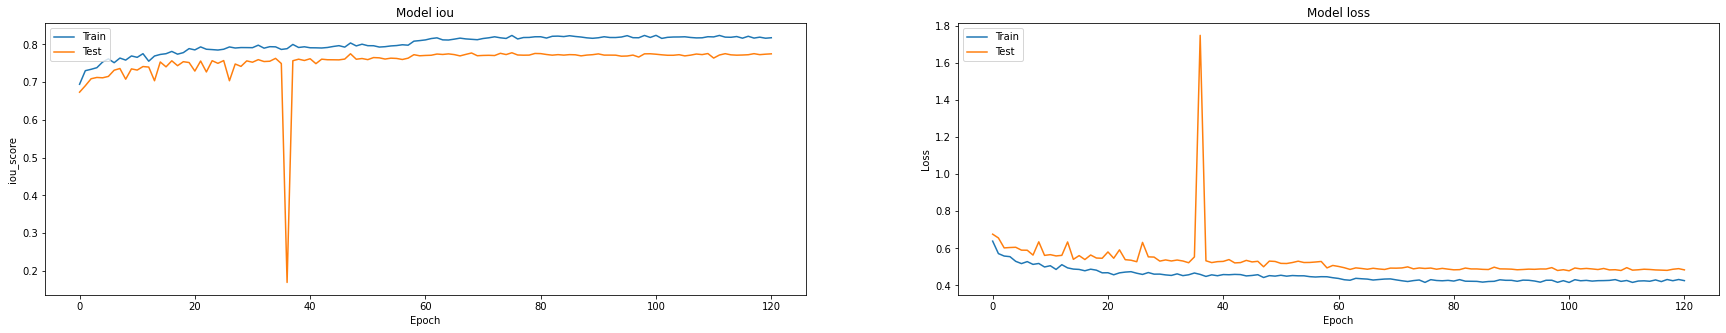

In [10]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model iou')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [7]:
model.load_weights('seresnet152_gen_roof_all.h5')

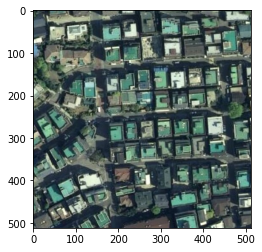

In [19]:
#Test on a different image
#READ EXTERNAL IMAGE...
#test_img = cv2.imread('C:\\Users\\User\\Desktop\\Jupyter\\rooftop_dataset\\mini_data\\LC_AP_37607046_078.tif', cv2.IMREAD_COLOR)       
#test_img = cv2.imread('LC_AP_37705083_001.tif', cv2.IMREAD_COLOR)
test_img = cv2.imread('dongjak.jpg', cv2.IMREAD_COLOR)

test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
#test_img = np.reshape(test_img,(512,512,1))
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

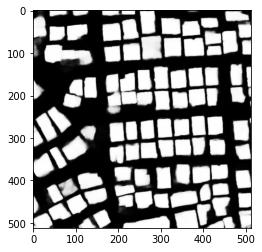

In [20]:
prediction_image1 = prediction.reshape(512,512,1)
plt.imshow(prediction_image1, cmap='gray')

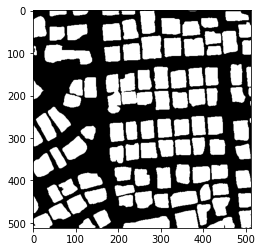

In [21]:
prediction_image1 = prediction.reshape(512,512,1)
prediction_image1 = prediction_image1 > 0.5
prediction_image1 = prediction_image1 * 255.
plt.imshow(prediction_image1, cmap='gray')

#cv2.imwrite('.tif', grayImg)

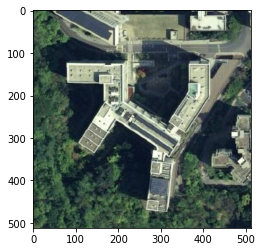

In [22]:
#Test on a different image
#READ EXTERNAL IMAGE...
#test_img = cv2.imread('C:\\Users\\User\\Desktop\\Jupyter\\rooftop_dataset\\mini_data\\LC_AP_37607046_078.tif', cv2.IMREAD_COLOR)       
#test_img = cv2.imread('LC_AP_37705083_001.tif', cv2.IMREAD_COLOR)
test_img = cv2.imread('CAU.jpg', cv2.IMREAD_COLOR)

test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
#test_img = np.reshape(test_img,(512,512,1))
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

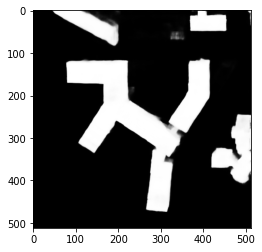

In [23]:
prediction_image1 = prediction.reshape(512,512,1)
plt.imshow(prediction_image1, cmap='gray')

True

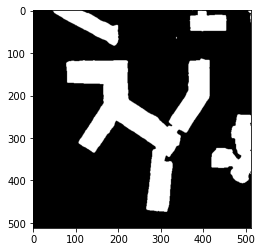

In [26]:
prediction_image1 = prediction.reshape(512,512,1)
prediction_image1 = prediction_image1 > 0.5
prediction_image1 = prediction_image1 * 255.
plt.imshow(prediction_image1, cmap='gray')

cv2.imwrite('CAU_mask.jpg', prediction_image1)

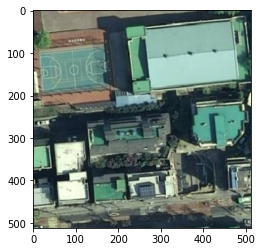

In [27]:
#Test on a different image
#READ EXTERNAL IMAGE...
#test_img = cv2.imread('C:\\Users\\User\\Desktop\\Jupyter\\rooftop_dataset\\mini_data\\LC_AP_37607046_078.tif', cv2.IMREAD_COLOR)       
#test_img = cv2.imread('LC_AP_37705083_001.tif', cv2.IMREAD_COLOR)
test_img = cv2.imread('AnyConv.com__croped.tif', cv2.IMREAD_COLOR)

test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
#test_img = np.reshape(test_img,(512,512,1))
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

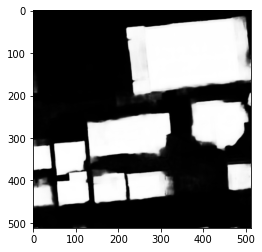

In [28]:
prediction_image1 = prediction.reshape(512,512,1)
plt.imshow(prediction_image1, cmap='gray')

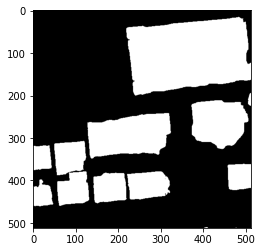

In [29]:
prediction_image1 = prediction.reshape(512,512,1)
prediction_image1 = prediction_image1 > 0.5
prediction_image1 = prediction_image1 * 255.
plt.imshow(prediction_image1, cmap='gray')

#cv2.imwrite('CAU_mask.jpg', prediction_image1)

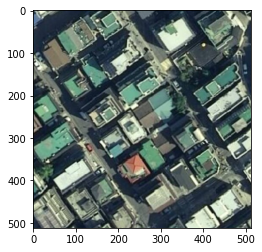

In [25]:
#Test on a different image
#READ EXTERNAL IMAGE...
#test_img = cv2.imread('C:\\Users\\User\\Desktop\\Jupyter\\rooftop_dataset\\mini_data\\LC_AP_37607046_078.tif', cv2.IMREAD_COLOR)       
#test_img = cv2.imread('LC_AP_37705083_001.tif', cv2.IMREAD_COLOR)
test_img = cv2.imread('dongjak_close.jpg', cv2.IMREAD_COLOR)

test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
#test_img = np.reshape(test_img,(512,512,1))
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

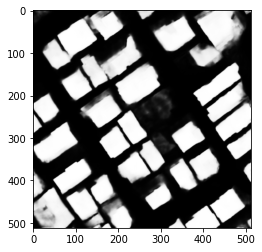

In [26]:
prediction_image1 = prediction.reshape(512,512,1)
plt.imshow(prediction_image1, cmap='gray')

In [ ]:
prediction_image1 = prediction.reshape(512,512,1)
prediction_image1 = prediction_image1 > 0.6
prediction_image1 = prediction_image1 * 255.
plt.imshow(prediction_image1, cmap='gray')